# Make the photometry of the companion star

- author : Sylvie Dagoret
- date June 17 2019

Use Photutils

In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

import numpy as np

from scipy.interpolate import interp1d

from astropy.time import Time

In [2]:
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import DAOStarFinder
from photutils import make_source_mask
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

In [3]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)

spectractordir=workbookDir+"/../../Spectractor"
print('spectractordir: ' + spectractordir)
toolsdir=workbookDir+"/../common_tools"
print("toolsdir:",toolsdir)


import sys
sys.path.append(workbookDir)
sys.path.append(spectractordir)
sys.path.append(os.path.dirname(workbookDir))
sys.path.append(toolsdir)



from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.logbook import LogBook
from spectractor.extractor.dispersers import *
from spectractor.extractor.spectrum import *
from spectractor.tools import ensure_dir

from libatmscattering import *


plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(15,15)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points



workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None
spectractordir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../../Spectractor
toolsdir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../common_tools


In [4]:
######### CONFIGURATION

## wavelength
WLMIN = 380.0
WLMAX = 1000.0
#NBWLBIN = 62
NBWLBIN = 124
WLBINWIDTH = (WLMAX - WLMIN) / float(NBWLBIN)

WLMINBIN = np.arange(WLMIN, WLMAX, WLBINWIDTH)
WLMAXBIN = np.arange(WLMIN + WLBINWIDTH, WLMAX + WLBINWIDTH, WLBINWIDTH)
WLMEANBIN=(WLMINBIN + WLMAXBIN)/2.



print('WLMINBIN..................................=', WLMINBIN.shape, WLMINBIN)
print('WLMAXBIN..................................=', WLMAXBIN.shape, WLMAXBIN)
print('NBWLBIN...................................=', NBWLBIN)
print('WLBINWIDTH................................=', WLBINWIDTH)

## colors

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBWLBIN)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBWLBIN), alpha=1)

## output directory for tables
#ouputtabledir="outputtabledir"

## create output directory
#ensure_dir(ouputtabledir)

WLMINBIN..................................= (124,) [380. 385. 390. 395. 400. 405. 410. 415. 420. 425. 430. 435. 440. 445.
 450. 455. 460. 465. 470. 475. 480. 485. 490. 495. 500. 505. 510. 515.
 520. 525. 530. 535. 540. 545. 550. 555. 560. 565. 570. 575. 580. 585.
 590. 595. 600. 605. 610. 615. 620. 625. 630. 635. 640. 645. 650. 655.
 660. 665. 670. 675. 680. 685. 690. 695. 700. 705. 710. 715. 720. 725.
 730. 735. 740. 745. 750. 755. 760. 765. 770. 775. 780. 785. 790. 795.
 800. 805. 810. 815. 820. 825. 830. 835. 840. 845. 850. 855. 860. 865.
 870. 875. 880. 885. 890. 895. 900. 905. 910. 915. 920. 925. 930. 935.
 940. 945. 950. 955. 960. 965. 970. 975. 980. 985. 990. 995.]
WLMAXBIN..................................= (124,) [ 385.  390.  395.  400.  405.  410.  415.  420.  425.  430.  435.  440.
  445.  450.  455.  460.  465.  470.  475.  480.  485.  490.  495.  500.
  505.  510.  515.  520.  525.  530.  535.  540.  545.  550.  555.  560.
  565.  570.  575.  580.  585.  590.  595.  600. 

In [5]:
#---------------------------------------------------------------------
def GetWLBin(wl):
    """

    :param wl: wavelength scalar
    :return: index
    """

    set_ibin = np.where(np.logical_and(WLMINBIN <= wl, WLMAXBIN > wl))[0]

    if len(set_ibin)==1:
        return set_ibin[0]
    else:
        return -1
#---------------------------------------------------------------------
def GETWLLabels():

    all_labels=[]
    for idx in np.arange(NBWLBIN):
        label="$\lambda$ : {:3.0f}-{:3.0f} nm".format(WLMINBIN[idx], WLMAXBIN[idx])
        all_labels.append(label)
    all_labels=np.array(all_labels)
    return all_labels
#------------------------------------------------------------------------

WLLABELS=GETWLLabels()

In [6]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    
    For example for the PSF
    
    x=pixel number
    y=Intensity in pixel
    
    values-x
    weights=y=f(x)
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)  # Fast and numerically precise
    return average, np.sqrt(variance)


In [7]:
def ComputeStarPhotometry(image):
    """

    :param image:
    :return:
    """

    mask = make_source_mask(image, snr=3, npixels=5, dilate_size=11)
    mean, median, std = sigma_clipped_stats(image, sigma=3.0, mask=mask)
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    signal = image - bkg.background
    mean, median, std = sigma_clipped_stats(signal, sigma=3.0)
    daofind = DAOStarFinder(fwhm=10.0, threshold=100. * std)
    sources = daofind(signal - median)
    for col in sources.colnames:
        sources[col].info.format = '%.8g'  # for consistent table output
    print(sources)

    #select the source having ymin
    allY=sources["ycentroid"]
    idx=np.where(allY==allY.min())[0][0]
    flux=sources["flux"][idx]
    mag=sources["mag"][idx]
    
    print(" idx={}".format(idx))
    
    return flux,mag

In [8]:
# where are the spectra
#----------------------
thedate = "20190215"
#input_directory = "/Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod3/" + thedate
input_directory = "/Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/" + thedate
rawinput_directory="/Users/dagoret/DATA/PicDuMidiFev2019/prod_"+thedate+"_v4"

In [9]:
#-------------------------------------------------------------------------------------
def GetAllFiles(dir):
    """
    GetAllFiles(dir): provides the list of relevant files inside the directory dir


    :param dir: input directory pathname
    :return: list of files
    """



    # get all files
    onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
    onlyfiles = np.array(onlyfiles)

    # sort files
    sortedindexes = np.argsort(onlyfiles)
    onlyfiles = onlyfiles[sortedindexes]

    # get only _spectrum.fits file
    onlyfilesspectrum = []
    for file_name in onlyfiles:
        if re.search("^T.*_spectrum.fits$", file_name):
            # check if other files exits

            filetype = file_name.split('.')[-1]

            output_filename = os.path.basename(file_name)
            output_filename = os.path.join(dir, output_filename)
            output_filename_spectrogram = output_filename.replace('spectrum', 'spectrogram')
            output_filename_psf = output_filename.replace('spectrum.fits', 'table.csv')

            # go to next simulation if output files already exists
            if os.path.isfile(output_filename) and os.path.isfile(output_filename_spectrogram) and os.path.isfile(
                    output_filename_psf):
                filesize = os.stat(output_filename).st_size
                print(">>>>> output filename : {} already exists with size {} ".format(output_filename, filesize))

                filesize = os.stat(output_filename_spectrogram).st_size
                print(">>>>> output filename : {} already exists with size {} ".format(output_filename_spectrogram,
                                                                                       filesize))

                filesize = os.stat(output_filename_psf).st_size
                print(">>>>> output filename : {} already exists with size {} ".format(output_filename_psf, filesize))

                onlyfilesspectrum.append(re.findall("(^T.*_spectrum.fits$)", file_name)[0])

    # sort again all the files
    onlyfilesspectrum = np.array(onlyfilesspectrum)
    sortedindexes = np.argsort(onlyfilesspectrum)
    onlyfilesspectrum = onlyfilesspectrum[sortedindexes]

    # get basnemae of files for later use (to check if _table.csv and _spectrogram.fits exists
    onlyfilesbasename = []
    for f in onlyfilesspectrum:
        onlyfilesbasename.append(re.findall("(^T.*)_spectrum.fits$", f)[0])


    return onlyfilesspectrum,onlyfilesbasename

In [10]:
def ReadAllFiles(dir, filelist):
    """

    ReadAllFiles(dir, filelist): Read all files

    :param dir: input directory
    :param filelist: list fo files
    :return: various containers
    """


    # init all container
    all_indexes=[]   # continuous index
    all_eventnum=[]  # event number on filename

    all_airmass=[]   #airmass

    all_lambdas = [] # wavelength

    #fluxes
    all_flux=[]
    all_errflux=[]


    # magnitudes
    all_mag=[]
    all_errmag=[]

    # absorption (Magnitude corrected from Rayleigh
    all_abs=[]
    all_errabs=[]


    all_dt       = []   # time since beginning in hours
    all_datetime = []   # datetime

    # preselection flag
    all_flag = []


    #bad indexes and filename
    all_badidx=[]
    all_badfn=[]


    all_BGimg=[]
    all_Rawimg=[]

    NBSPEC = len(filelist)


    #----------------------------------
    # Extract spectra information from files
    # compute magnitudes
    #-----------------------------

    count=-1  #counter of good files before filtering

    # loop on all files
    for idx in np.arange(0, NBSPEC):
        if idx==322:
            print("SKIP bad file",filelist[idx] )
            continue

        count+=1

        theeventnum = int(filelist[idx].split(".")[1].split("_")[0])


        print(" read {}) : event {} , file {}".format(idx,theeventnum,filelist[idx]))


        fullfilename = os.path.join(dir, filelist[idx])
        fullfilename_spectrogram = fullfilename.replace('spectrum', 'spectrogram')
        rawfilename = filelist[idx].replace('_spectrum.fits', '.fit')
        fillrawfilename=os.path.join(rawinput_directory,rawfilename)
        

        #try:
        if 1:
            # read fits file
            hdu = fits.open(fullfilename)
            hdu2=fits.open(fullfilename_spectrogram)
            hdu3=fits.open(fillrawfilename)

            

            # decode header
            header=hdu[0].header

            am=header["AIRMASS"]
            date=header["DATE-OBS"]

            if idx==0:
                T0=t = Time(date, format='isot', scale='utc')
            T=Time(date, format='isot', scale='utc')
            thedatetime=T.to_datetime()

            DT=(T-T0).sec/(3600.0)  # convert in hours


            # decode data
            data=hdu[0].data

            # extract wavelength, spectrum and errors
            wavelength=data[0,:]
            spec = data[1,:]
            err=data[2,: ]

            if(len(wavelength)==0 or len(spec)==0 or len(err)==0):
                print(">>>>>>>>>>>>>>  Empty file ",idx,")::",onlyfilesspectrum[idx] )
                print(">>>>>>>>>>>>>>>>>>>>>>>>>>>",len(wavelength)," , ",len(spec0), " , ",len(err))



            # sort the wavelengths
            wl_sorted_idx=np.argsort(wavelength)

            wl=wavelength[wl_sorted_idx]
            fl=spec[wl_sorted_idx]
            errfl=err[wl_sorted_idx]
            wlbins = [GetWLBin(w) for w in wl]
            wlbins = np.array(wlbins)


            # defines good measurmements as flux >0 and wavelength in selected bons
            goodpoints=np.where(np.logical_and(fl != 0, wlbins != -1))

            if(len(goodpoints)==0):
                print(">>>>>>>>>>>>>>  No Good points  ", idx, ")::", onlyfilesspectrum[idx])
                print(">>>>>>>>>>>>>>  No Good points  ", "wl = ",wl)
                print(">>>>>>>>>>>>>>  No Good points  ", "fl = ", fl)
                print(">>>>>>>>>>>>>>  No Good points  ", "errfl = ", errfl)



            # keep good points (wl,flux)
            wl=wl[goodpoints]
            fl=fl[goodpoints]
            errfl=errfl[goodpoints]


            # convert flux into magnitudes for each wavelength
            mag = -2.5 * np.log10(fl)
            errmag = errfl/fl

            #compute effective slant Rayleigh optical depth (not the vertical optical depth)
            od_adiab = RayOptDepth_adiabatic(wl,altitude=2890.5, costh=1./am)  # Rayleigh optical depth

            # absorption magnitude corrected from Rayleigh attenuation
            abs=mag-2.5/np.log(10.)*od_adiab
            errabs=errmag





            # save for each observation  { event-id, airmass, set of points (wl,flux,errflux, mag,abs,errabs) }
            if(len(mag>0)):
                #all_indexes.append(idx)
                all_indexes.append(count)
                all_eventnum.append(theeventnum)
                all_airmass.append(am)
                all_lambdas.append(wl)
                all_flux.append(fl)
                all_errflux.append(errfl)
                all_mag.append(mag)
                all_errmag.append(errmag)
                all_abs.append(abs)
                all_errabs.append(errabs)
                all_dt.append(DT)
                all_datetime.append(thedatetime)
                all_BGimg.append(hdu2[2].data)
                all_Rawimg.append(hdu3[0].data)

                absmin = abs.min()
                absmax = abs.max()


                # Set a quality flag
                if absmin < 25 or absmax > 32:
                    print("file index idx = ", count, "==>  filename = ", onlyfilesspectrum[idx], " absmin= ", absmin,
                          " absmax = ", absmax)
                    all_flag.append(False)
                    all_badidx.append(count)
                    all_badfn.append(onlyfilesspectrum[idx])
                else:
                    all_flag.append(True)



        #except:
        if 0:
            print("Unexpected error:", sys.exc_info()[0])
            pass

    # transform container in numpy arrays
    all_indexes=np.array(all_indexes)
    all_eventnum = np.array(all_eventnum)

    all_airmass = np.array(all_airmass)

    all_lambdas = np.array(all_lambdas)

    all_flux = np.array(all_flux)
    all_errflux = np.array(all_errflux)


    all_mag=np.array(all_mag)
    all_errmag=np.array(all_errmag)

    all_abs = np.array(all_abs)
    all_errabs = np.array(all_errabs)

    all_dt = np.array(all_dt)
    all_datetime=np.array(all_datetime)

    all_flag = np.array(all_flag)

    all_badidx=np.array(all_badidx)
    all_badfn=np.array(all_badfn)


    return all_indexes,all_eventnum,all_airmass,all_lambdas,all_flux,all_errflux,all_mag,all_errmag,all_abs,all_errabs,all_dt,all_datetime,all_flag,all_badidx,all_badfn, all_BGimg, all_Rawimg


In [11]:
#############################################
# 1) Get list of files
##########################################
onlyfilesspectrum,onlyfilesbasename=GetAllFiles(input_directory)



>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrum.fits already exists with size 54720 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrogram.fits already exists with size 40700160 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_table.csv already exists with size 640113 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red_spectrum.fits already exists with size 54720 
>>>>> output filename : /Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/20190215/T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red_spectrogram.fits already exists with size 408297

In [12]:
#############################################
# 2) Read fits file
##########################################


NBSPEC = len(onlyfilesspectrum)

print('NBSPEC....................................= ', NBSPEC)


all_indexes, all_eventnum, all_airmass, all_lambdas, all_flux, all_errflux, all_mag, all_errmag, all_abs, all_errabs, all_dt, all_datetime, all_flag, all_badidx, all_badfn, all_BGimg, all_Rawimg=ReadAllFiles(input_directory, onlyfilesspectrum)


NBSPEC....................................=  348
 read 0) : event 1 , file T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrum.fits
 read 1) : event 2 , file T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red_spectrum.fits
 read 2) : event 3 , file T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red_spectrum.fits
 read 3) : event 4 , file T1M_20190215_225736_562_HD116405_Filtre_None_bin1x1.4_red_spectrum.fits
 read 4) : event 5 , file T1M_20190215_225811_838_HD116405_Filtre_None_bin1x1.5_red_spectrum.fits
 read 5) : event 6 , file T1M_20190215_225847_115_HD116405_Filtre_None_bin1x1.6_red_spectrum.fits
 read 6) : event 7 , file T1M_20190215_225922_399_HD116405_Filtre_None_bin1x1.7_red_spectrum.fits
 read 7) : event 8 , file T1M_20190215_225957_677_HD116405_Filtre_None_bin1x1.8_red_spectrum.fits
 read 8) : event 9 , file T1M_20190215_230032_956_HD116405_Filtre_None_bin1x1.9_red_spectrum.fits
 read 9) : event 10 , file T1M_20190215_230108_233_HD116405_Filtre_No

 read 81) : event 82 , file T1M_20190215_234328_257_HD116405_Filtre_None_bin1x1.82_red_spectrum.fits
 read 82) : event 83 , file T1M_20190215_234403_534_HD116405_Filtre_None_bin1x1.83_red_spectrum.fits
 read 83) : event 84 , file T1M_20190215_234438_829_HD116405_Filtre_None_bin1x1.84_red_spectrum.fits
 read 84) : event 85 , file T1M_20190215_234514_107_HD116405_Filtre_None_bin1x1.85_red_spectrum.fits
 read 85) : event 86 , file T1M_20190215_234549_469_HD116405_Filtre_None_bin1x1.86_red_spectrum.fits
 read 86) : event 87 , file T1M_20190215_234624_749_HD116405_Filtre_None_bin1x1.87_red_spectrum.fits
 read 87) : event 88 , file T1M_20190215_234700_026_HD116405_Filtre_None_bin1x1.88_red_spectrum.fits
 read 88) : event 89 , file T1M_20190215_234735_303_HD116405_Filtre_None_bin1x1.89_red_spectrum.fits
 read 89) : event 90 , file T1M_20190215_234810_580_HD116405_Filtre_None_bin1x1.90_red_spectrum.fits
 read 90) : event 91 , file T1M_20190215_234845_858_HD116405_Filtre_None_bin1x1.91_red_spec

 read 165) : event 62 , file T1M_20190216_005056_106_HD116405_Filtre_None_bin1x1.62_red_spectrum.fits
 read 166) : event 63 , file T1M_20190216_005131_383_HD116405_Filtre_None_bin1x1.63_red_spectrum.fits
 read 167) : event 64 , file T1M_20190216_005206_661_HD116405_Filtre_None_bin1x1.64_red_spectrum.fits
 read 168) : event 65 , file T1M_20190216_005241_938_HD116405_Filtre_None_bin1x1.65_red_spectrum.fits
 read 169) : event 66 , file T1M_20190216_005317_215_HD116405_Filtre_None_bin1x1.66_red_spectrum.fits
 read 170) : event 67 , file T1M_20190216_005352_494_HD116405_Filtre_None_bin1x1.67_red_spectrum.fits
 read 171) : event 68 , file T1M_20190216_005427_770_HD116405_Filtre_None_bin1x1.68_red_spectrum.fits
 read 172) : event 69 , file T1M_20190216_005503_048_HD116405_Filtre_None_bin1x1.69_red_spectrum.fits
 read 173) : event 70 , file T1M_20190216_005538_326_HD116405_Filtre_None_bin1x1.70_red_spectrum.fits
 read 174) : event 71 , file T1M_20190216_005613_605_HD116405_Filtre_None_bin1x1.7

 read 247) : event 237 , file T1M_20190216_025332_552_HD116405_Filtre_None_bin1x1.237_red_spectrum.fits
 read 248) : event 238 , file T1M_20190216_025407_836_HD116405_Filtre_None_bin1x1.238_red_spectrum.fits
 read 249) : event 239 , file T1M_20190216_025443_120_HD116405_Filtre_None_bin1x1.239_red_spectrum.fits
 read 250) : event 240 , file T1M_20190216_025518_405_HD116405_Filtre_None_bin1x1.240_red_spectrum.fits
 read 251) : event 241 , file T1M_20190216_025553_689_HD116405_Filtre_None_bin1x1.241_red_spectrum.fits
 read 252) : event 242 , file T1M_20190216_025628_979_HD116405_Filtre_None_bin1x1.242_red_spectrum.fits
 read 253) : event 267 , file T1M_20190216_031111_229_HD116405_Filtre_None_bin1x1.267_red_spectrum.fits
 read 254) : event 268 , file T1M_20190216_031146_520_HD116405_Filtre_None_bin1x1.268_red_spectrum.fits
 read 255) : event 269 , file T1M_20190216_031221_813_HD116405_Filtre_None_bin1x1.269_red_spectrum.fits
 read 256) : event 270 , file T1M_20190216_031257_100_HD116405_F

 read 291) : event 356 , file T1M_20190216_040608_852_HD116405_Filtre_None_bin1x1.356_red_spectrum.fits
 read 292) : event 357 , file T1M_20190216_040644_146_HD116405_Filtre_None_bin1x1.357_red_spectrum.fits
 read 293) : event 358 , file T1M_20190216_040719_441_HD116405_Filtre_None_bin1x1.358_red_spectrum.fits
 read 294) : event 364 , file T1M_20190216_041051_213_HD116405_Filtre_None_bin1x1.364_red_spectrum.fits
 read 295) : event 365 , file T1M_20190216_041126_502_HD116405_Filtre_None_bin1x1.365_red_spectrum.fits
file index idx =  295 ==>  filename =  T1M_20190216_041126_502_HD116405_Filtre_None_bin1x1.365_red_spectrum.fits  absmin=  26.421605193515344  absmax =  32.3916568191284
 read 296) : event 372 , file T1M_20190216_042315_191_HD116405_Filtre_None_bin1x1.372_red_spectrum.fits
 read 297) : event 373 , file T1M_20190216_042350_533_HD116405_Filtre_None_bin1x1.373_red_spectrum.fits
 read 298) : event 374 , file T1M_20190216_042425_815_HD116405_Filtre_None_bin1x1.374_red_spectrum.fit

In [13]:
NBSPEC

348

# Compute Photometry

In [14]:
all_mag=[]
all_flux=[]

idx=0
for img in all_Rawimg:
    print("************************************** {} ***************************************".format(idx))
    flux,mag=ComputeStarPhotometry(img)

    all_mag.append(mag)
    all_flux.append(flux)
    idx+=1
    
    if idx>50:
        break

all_mag=np.array(all_mag)
all_flux=np.array(all_flux)


print(all_mag)

************************************** 0 ***************************************
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 416.82351 89.841672 0.55505871 ...   0 42992.842 100.38375 -5.0041586
  2 131.36829 220.22089 0.39960266 ...   0 64575.844 91.987135 -4.9093177
  3 135.39846 222.28786  0.3248739 ...   0 64907.153 104.12482 -5.0438857
 idx=0
************************************** 1 ***************************************
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1  417.1429  86.10187 0.50750507 ...   0 38610.817 91.703377 -4.9059633
  2 135.51972  218.3431 0.37774926 ...   0  64351.84 98.452821 -4.9830704
 idx=0
************************************** 2 ***************************************
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
---

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1  450.0986  13.30818 0.47927803 ...   0 33239.137 79.623782  -4.752607
  2 166.19549 141.37029 0.35440784 ...   0 64989.174  146.1261 -5.4118195
  3 168.67001  145.2628 0.37736499 ...   0 65330.413 102.01359  -5.021645
 idx=0
************************************** 20 ***************************************
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 447.87011 11.050907 0.53624791 ...   0 38181.869 88.665011 -4.8693807
  2 162.46166 142.53981 0.32524147 ...   0 65518.077 91.994732 -4.9094074
  3 165.86004 143.55242 0.29287338 ...   0  65041.06 99.037901 -4.9895036
 idx=0
************************************** 21 ***************************************
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- ----

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 471.03983  48.37084 0.51456924 ...   0 34586.498 77.201965 -4.7190709
  2  185.3981 180.45352  0.3862738 ...   0 64911.921 91.129987 -4.8991533
  3 189.11909 179.89066 0.36086324 ...   0 64831.944 84.512048 -4.8172966
 idx=0
************************************** 36 ***************************************
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 469.58128 48.014178 0.54165742 ...   0 43454.687 101.45519 -5.0156856
  2 186.53006 181.45762 0.32703167 ...   0 64928.487 92.556455 -4.9160168
 idx=0
************************************** 37 ***************************************
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 382.

In [15]:
assert False

AssertionError: 

# Study a particular image

## Selection

In [16]:
index=32 # exemple de bougé
index=0 # image OK
image=all_Rawimg[index]
vmin=image.min()
vmax=image.max()/50.
thefilename=onlyfilesspectrum[index] #onlyfilesbasename

In [17]:
data=image

## Show raw image

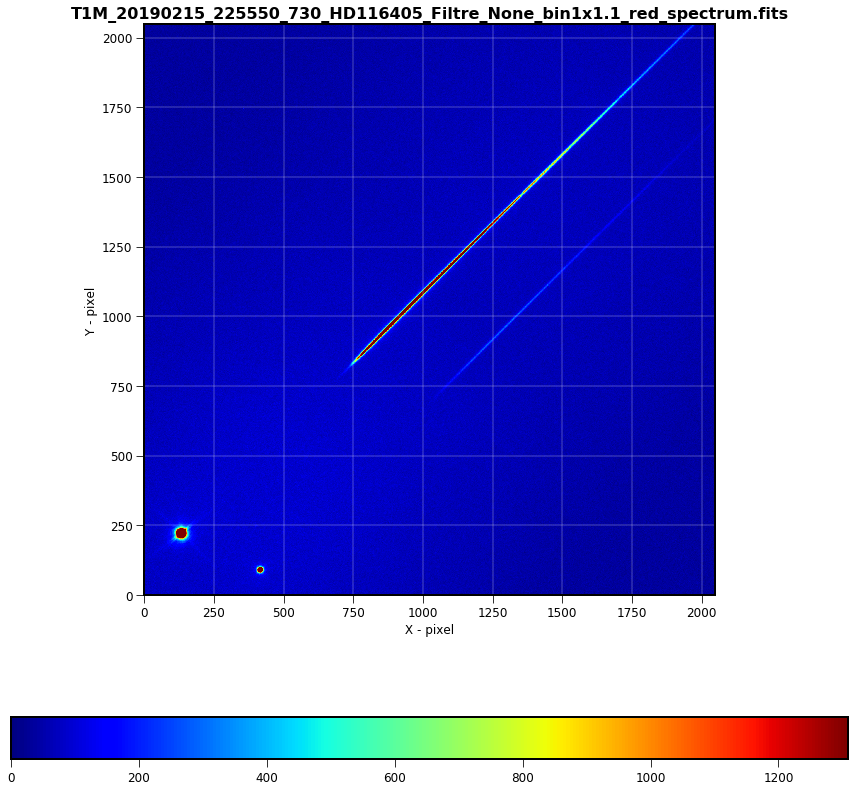

In [18]:
img=plt.imshow(data,origin="lower",vmin=vmin,vmax=vmax,cmap="jet")
plt.grid(color="w")
plt.title(thefilename)
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")
plt.colorbar(img,orientation="horizontal")

## Plot histogram

Text(0, 0.5, 'number of pixels')

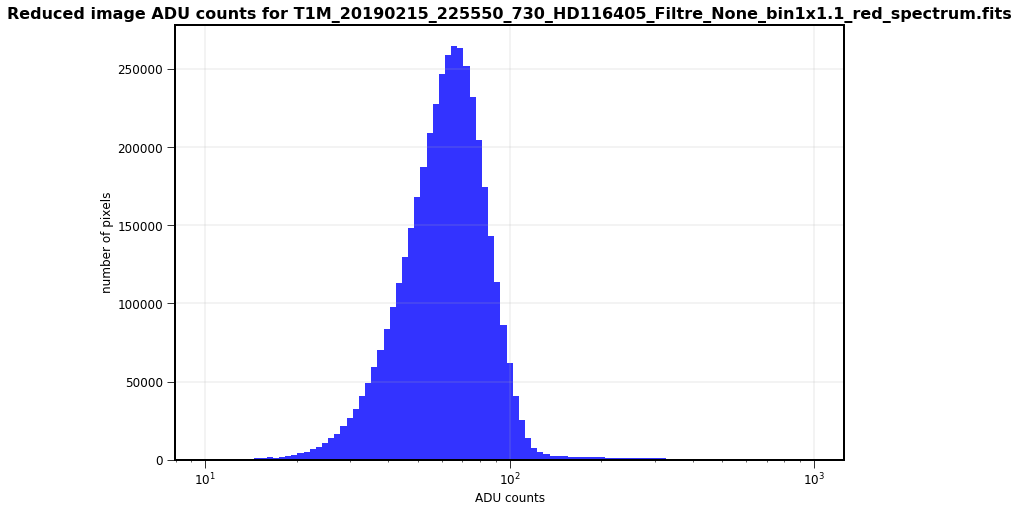

In [19]:
plt.figure(figsize=(12,8))
XMIN=10
XMAX=1000
plt.hist(data.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Reduced image ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [20]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
print((mean, median, std))    

(62.683913040066145, 62.160806867873916, 18.221840820359397)


## Search Sources in raw image

In [21]:
daofind = DAOStarFinder(fwhm=10.0, threshold=100.*std)    
sources = daofind(data - median) 

In [22]:
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)    

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 416.82349 89.841687 0.55505862 ...   0 43021.343 59.484191 -4.4360039
  2 131.36828 220.22083 0.39960252 ...   0 64617.914 54.508733 -4.3411652
  3 135.39845 222.28779 0.32487395 ...   0 64948.867 61.701166 -4.4757334


In [23]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,416.82349,89.841687,0.55505862,0.24712491,-0.027605732,169,0,43021.343,59.484191,-4.4360039
2,131.36828,220.22083,0.39960252,0.058765839,0.64615658,169,0,64617.914,54.508733,-4.3411652
3,135.39845,222.28779,0.32487395,-0.10523389,0.29876359,169,0,64948.867,61.701166,-4.4757334


Text(0, 0.5, ' Y - pixel ')

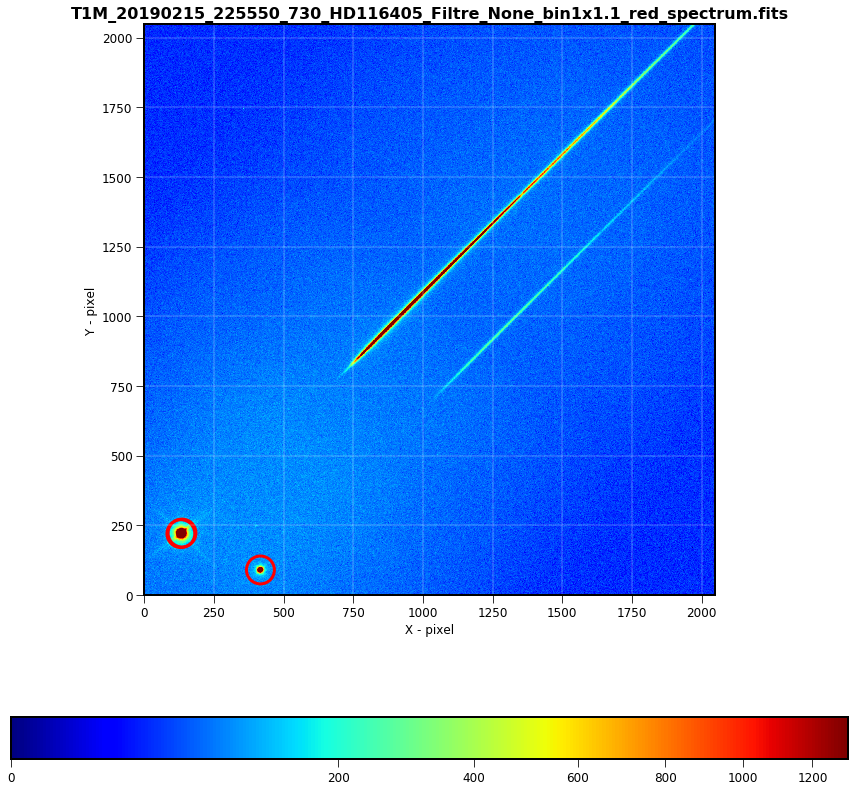

In [24]:
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
#plt.imshow(data,cmap='Greys', origin='lower', norm=norm)
img=plt.imshow(data,cmap='jet', origin='lower', norm=norm,vmin=vmin,vmax=vmax)
apertures.plot(color='red', lw=3, alpha=1.0)

plt.grid(color="w")
plt.title(thefilename)
plt.colorbar(img,orientation="horizontal")
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")

## Background extraction

In [25]:
mask = make_source_mask(data, snr=3, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
print((mean, median, std))  

(62.30552023394993, 61.8784901294212, 17.94569493503539)


In [ ]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [ ]:
#img=plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(bkg.background, origin='lower', cmap='jet')
plt.grid(color="w")
plt.title("Background for {}".format(thefilename))
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")
plt.colorbar(img,orientation="horizontal")

In [ ]:
plt.figure(figsize=(12,8))
XMIN=10
XMAX=1000
plt.hist(bkg.background.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Background ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
plt.figure(figsize=(12,8))
XMIN=20
XMAX=100
plt.hist(bkg.background.flatten(), bins = np.linspace(XMIN,XMAX, 100),color="b",alpha=0.8)
#plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Background ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
signal=data - bkg.background
vmin=signal.min()
vmax=signal.max()/50.
#plt.imshow(signal, norm=norm, origin='lower',cmap='Greys_r',vmin=vmin,vmax=vmax)
img=plt.imshow(signal, norm=norm, origin='lower',cmap='jet',vmin=vmin,vmax=vmax)
plt.colorbar(img,orientation="horizontal")
plt.title("Signal for {}".format(thefilename))
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")
plt.grid(color="w")

In [ ]:
mean, median, std = sigma_clipped_stats(signal, sigma=3.0)    
print((mean, median, std))    

In [ ]:
daofind = DAOStarFinder(fwhm=10.0, threshold=100.*std)    
sources = daofind(data - median) 

In [ ]:
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)   

In [ ]:
sources

In [ ]:
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
#plt.imshow(data,cmap='Greys', origin='lower', norm=norm)
img=plt.imshow(signal,cmap='jet', origin='lower', norm=norm,vmin=vmin,vmax=vmax)
apertures.plot(color='red', lw=3, alpha=1.0)
plt.grid(color="w")
plt.title("Signal for {}".format(thefilename))
plt.colorbar(img,orientation="horizontal")
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")

In [ ]:
plt.figure(figsize=(12,8))
XMIN=0.01
XMAX=10000
plt.hist(signal.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Signal ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
x0=sources["xcentroid"][0]
y0=sources["ycentroid"][0]
siz=20
pixel_to_arcsec=0.159
extent=(-siz*pixel_to_arcsec,siz*pixel_to_arcsec, -siz*pixel_to_arcsec,siz*pixel_to_arcsec )

In [ ]:
vignette=signal[int(y0-siz):int(y0+siz),int(x0-siz):int(x0+siz)]

In [ ]:
plt.figure(figsize=(12,8))
XMIN=10
XMAX=100000
plt.hist(vignette.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Star ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
img=plt.imshow(vignette,origin="lower",cmap="jet",extent=extent)
plt.colorbar(img,orientation="horizontal")
plt.xlabel("$\\theta_X$ (arcsec)")
plt.ylabel("$\\theta_Y$ (arcsec)")
plt.title(thefilename)
plt.grid(color="white")

In [ ]:
histx=vignette.sum(axis=0)
histy=vignette.sum(axis=1)

In [ ]:
lx=len(histx)
ly=len(histy)
mx,sx=weighted_avg_and_std(np.arange(lx),histx)
my,sy=weighted_avg_and_std(np.arange(ly),histy)
hxmin,hxmax=histx.min(),histx.max()
hymin,hymax=histy.min(),histy.max()
hxaver=(hxmin+hxmax)/2.
hyaver=(hymin+hymax)/2.

In [ ]:
sx,sy

In [ ]:
plt.subplot(221)
plt.plot(histx,'b-o')
plt.plot([mx,mx],[hxmin,hxmax],"r-")
plt.plot([(lx+1.)/2.-2.36/2.*sx, (lx+1)/2.+2.36/2.*sx],[hxaver,hxaver],"g-")
plt.xlabel("x - pixel")
plt.title("$\sigma_x$= {:1.2f} pix = {:1.2f} arcsec".format(sx,sx*pixel_to_arcsec))
plt.grid()
plt.subplot(222)
plt.plot(histy,'b-o')
plt.plot([my,my],[hymin,hymax],"r-")
plt.plot([(ly+1)/2.-2.36/2.*sy, (ly+1)/2.+2.36/2.*sy],[hyaver,hyaver],"g-")
plt.xlabel("y - pixel")
plt.title("$\sigma_y$= {:1.2f} pix = {:1.2f} arcsec".format(sy,sy*pixel_to_arcsec))
plt.grid()
plt.suptitle(thefilename,fontsize=20)